In [25]:
import pandas as pd
import numpy as np
import graphviz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats
import warnings

from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot, add_constant
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 환경에서는 'Malgun Gothic' 폰트를 사용
else:
    plt.rcParams['font.family'] = 'NanumGothic'  # macOS나 Linux 등 다른 환경에서는 'AppleGothic' 폰트를 사용

matplotlib.rcParams['axes.unicode_minus'] = False

In [5]:
df_raw = pd.read_csv('./SCALE불량.csv', encoding='cp949')
df_raw.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1열,1144,116,1133,59,259,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,2열,1144,122,1135,53,238,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1열,1129,116,1121,55,258,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,2열,1152,125,1127,68,266,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1열,1140,134,1128,48,246,TMCP(온도제어),873,8,1조


In [7]:
df_raw.columns

Index(['plate_no', 'rolling_date', 'scale', 'spec_long', 'spec_country',
       'steel_kind', 'pt_thick', 'pt_width', 'pt_length', 'hsb', 'fur_no',
       'fur_input_row', 'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp',
       'fur_soak_time', 'fur_total_time', 'rolling_method', 'rolling_temp',
       'descaling_count', 'work_group'],
      dtype='object')

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   object
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   object
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   object
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   object
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  rolling_method   1000 non-null   o

In [10]:
df_raw.isnull().sum()

plate_no           0
rolling_date       0
scale              0
spec_long          0
spec_country       0
steel_kind         0
pt_thick           0
pt_width           0
pt_length          0
hsb                0
fur_no             0
fur_input_row      0
fur_heat_temp      0
fur_heat_time      0
fur_soak_temp      0
fur_soak_time      0
fur_total_time     0
rolling_method     0
rolling_temp       0
descaling_count    0
work_group         0
dtype: int64

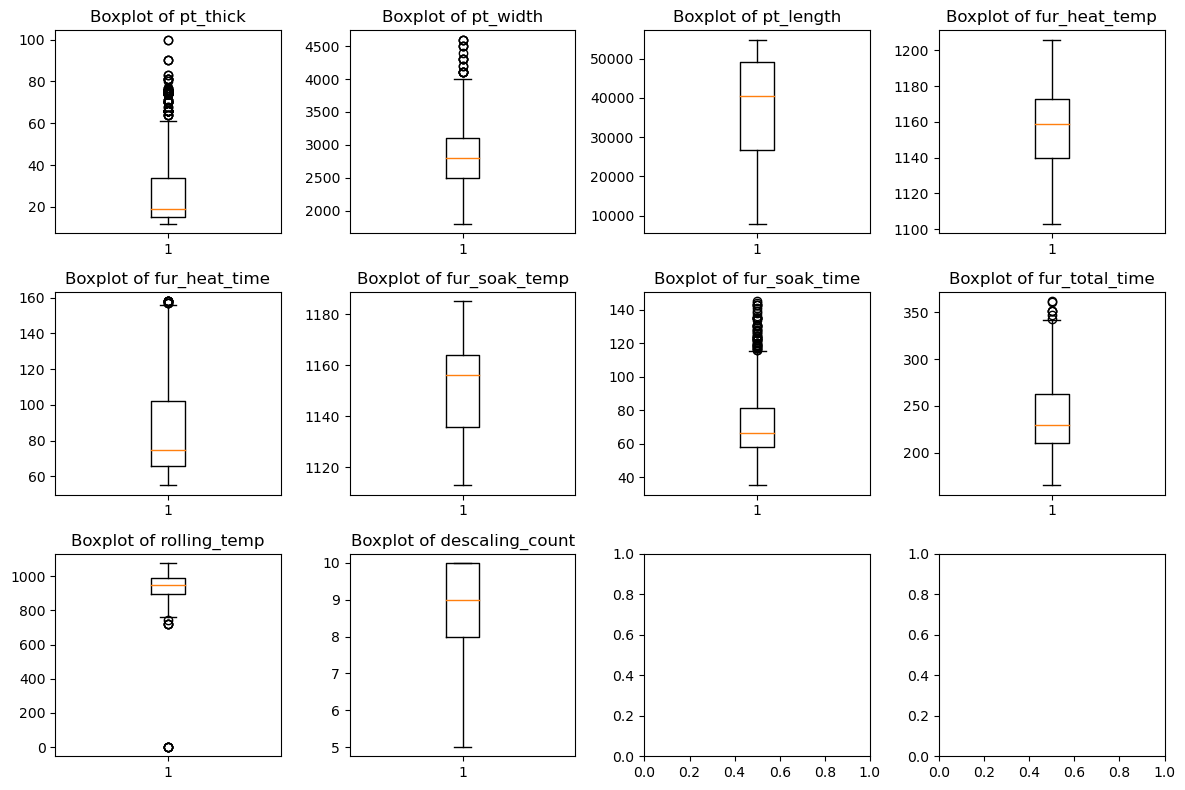

In [9]:
# 이상치 확인
variables = ['pt_thick', 'pt_width', 'pt_length', 'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp', 'fur_soak_time',
             'fur_total_time', 'rolling_temp', 'descaling_count']

# Boxplot
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))  # 3행 4열의 subplot 생성
axes = axes.flatten()  # 2차원 배열을 1차원으로 펼치기

for i, variable in enumerate(variables):
    axes[i].boxplot(df_raw[variable])
    axes[i].set_title(f"Boxplot of {variable}")

# subplot 간 간격 조정
plt.tight_layout()

# 그래프 출력
plt.show()

In [16]:
# 이상치 검출 
def outlier(df, variable):
    Q1 = df[variable].quantile(0.25)
    Q3 = df[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[variable] < lower_bound) | (df[variable] > upper_bound)]
    return outliers, lower_bound, upper_bound

# 각 변수의 이상치 및 경계값을 저장하는 리스트 초기화
outlier_list = []
bounds_list = []

# 변수별 이상치 탐지
for variable in variables:
    outliers, lower_bound, upper_bound = outlier(df_raw, variable)
    outlier_list.append(outliers)
    bounds_list.append((lower_bound, upper_bound))

# 이상치 개수 및 경계값 출력
for i, variable in enumerate(variables):
    lower_bound, upper_bound = bounds_list[i]
    print(f"{variable} 이상치 개수: {outlier_list[i].shape[0]}")
    print(f"{variable} 이상치 기준: {lower_bound:.2f} 미만, {upper_bound:.2f} 초과\n")

pt_thick 이상치 개수: 83
pt_thick 이상치 기준: -13.50 미만, 62.50 초과

pt_width 이상치 개수: 19
pt_width 이상치 기준: 1600.00 미만, 4000.00 초과

pt_length 이상치 개수: 0
pt_length 이상치 기준: -7025.00 미만, 82775.00 초과

fur_heat_temp 이상치 개수: 0
fur_heat_temp 이상치 기준: 1090.50 미만, 1222.50 초과

fur_heat_time 이상치 개수: 10
fur_heat_time 이상치 기준: 11.62 미만, 156.62 초과

fur_soak_temp 이상치 개수: 0
fur_soak_temp 이상치 기준: 1093.38 미만, 1206.38 초과

fur_soak_time 이상치 개수: 49
fur_soak_time 이상치 기준: 22.88 미만, 115.88 초과

fur_total_time 이상치 개수: 7
fur_total_time 이상치 기준: 130.50 미만, 342.50 초과

rolling_temp 이상치 개수: 11
rolling_temp 이상치 기준: 747.88 미만, 1136.88 초과

descaling_count 이상치 개수: 0
descaling_count 이상치 기준: 5.00 미만, 13.00 초과



In [11]:
# 압연온도 0도 
df_raw[df_raw['rolling_temp'] == 0.00000]

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group
53,PLT_1054,03JAN2023:16:22:29,양품,GL-E36-TM,독일,T,56,3800,11400,적용,...,2열,1132,95,1128,80,244,TMCP(온도제어),0,6,1조
221,PLT_1222,04JAN2023:19:44:09,양품,JS-SM490YB,일본,C,16,2200,43600,적용,...,2열,1163,57,1166,67,228,CR(제어압연),0,10,2조
222,PLT_1223,04JAN2023:19:56:39,양품,JS-SM490YB,일본,C,16,2200,43600,적용,...,1열,1169,64,1164,61,188,CR(제어압연),0,10,2조
598,PLT_1599,07JAN2023:11:40:51,양품,PILAC-BT33,한국,T,81,2100,12900,적용,...,1열,1133,89,1122,59,229,CR(제어압연),0,6,3조
599,PLT_1600,07JAN2023:11:52:00,양품,PILAC-BT33,한국,T,81,2100,13200,적용,...,2열,1130,92,1124,61,210,CR(제어압연),0,6,3조
600,PLT_1601,07JAN2023:11:59:10,양품,NV-D32-TM,영국,T,40,2500,23600,적용,...,1열,1119,109,1117,76,260,TMCP(온도제어),0,6,3조


In [36]:
df_raw['scale'].describe()

count     1000
unique       2
top         양품
freq       690
Name: scale, dtype: object

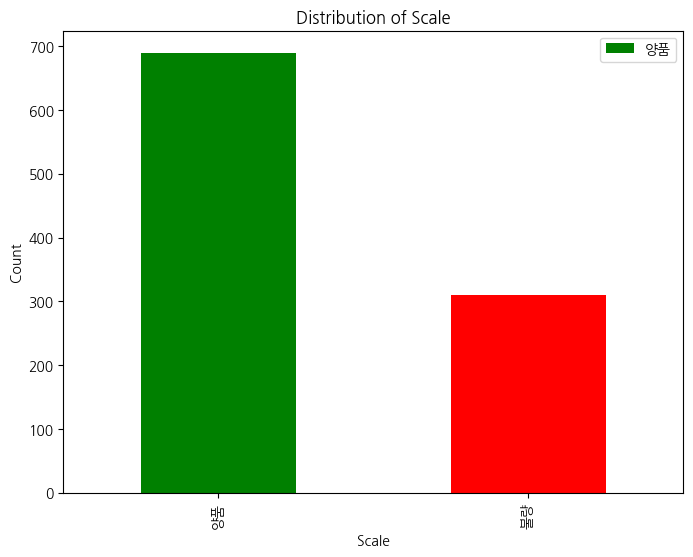

In [29]:
# 목표변수 scale값에 따른 빈도수 계산
scale_counts = df_raw['scale'].value_counts()

# 양품과 불량의 색상 설정
colors = ['green', 'red']

# 막대 그래프 그리기
plt.figure(figsize=(8, 6))
scale_counts.plot(kind='bar', color=colors)

# 범례 추가
plt.legend(labels=scale_counts.index)

plt.xlabel('Scale')
plt.ylabel('Count')
plt.title('Distribution of Scale')
plt.show()


In [37]:
df_raw['scale'] = df_raw['scale'].map(lambda x : 0 if x == '양품' else 1) #양품을 0, 불량을 1로 매핑
df_raw['scale'].head()

0    0
1    0
2    0
3    0
4    0
Name: scale, dtype: int64

In [38]:
#T = 1, C = 2
df_raw['steel_kind'].unique()

array(['T', 'C'], dtype=object)

In [39]:
# steel_kind 변수 값 변환 및 데이터 타입 변경
df_raw['steel_kind'] = df_raw['steel_kind'].map({'T': 1, 'C': 2}).astype(int)

In [40]:
#적용 = 1, 미적용 = 2
df_raw['hsb'].unique()

array(['적용', '미적용'], dtype=object)

In [41]:
# hsb 변수 값 변환 및 데이터 타입 변경
df_raw['hsb'] = df_raw['hsb'].map({'적용': 1, '미적용': 2}).astype(int)

In [42]:
#1호기 = 1, 2호기 = 2, 3호기 = 3
df_raw['fur_no'].unique()

array(['1호기', '2호기', '3호기'], dtype=object)

In [43]:
#1열 = 1, 2열 = 2
df_raw['fur_input_row'].unique()

array(['1열', '2열'], dtype=object)

In [44]:
# fur_input_row 변수 값 변환 및 데이터 타입 변경
df_raw['fur_input_row'] = df_raw['fur_input_row'].map({'1열': 1, '2열': 2}).astype(int)

In [45]:
#TMCP = 1, CR = 2
df_raw['rolling_method'].unique()

array(['TMCP(온도제어)', 'CR(제어압연)'], dtype=object)

In [46]:
import re

# rolling_method 변수 값에서 기호와 문자열 삭제
df_raw['rolling_method'] = df_raw['rolling_method'].apply(lambda x: re.sub(r'\W.*$', '', x)) 
# rolling_method 변수 값 변환 및 데이터 타입 변경
df_raw['rolling_method'] = df_raw['rolling_method'].replace({'TMCP': 1, 'CR': 2}).astype(int)

In [47]:
#1조 = 1, 2조 = 2, 3조 = 3, 4조 = 4
df_raw['work_group'].unique()

array(['1조', '2조', '3조', '4조'], dtype=object)

In [48]:
# work_group 변수 값 변환 및 데이터 타입 변경
df_raw['work_group'] = df_raw['work_group'].replace({'1조': 1, '2조': 2, '3조': 3, '4조': 4}).astype(int)

In [54]:
# rolling_data를 datetime 형식으로 변환 
df_raw['rolling_date'] = pd.to_datetime(df['rolling_date'], format='%d%b%Y:%H:%M:%S')
pd.set_option('display.max_columns', None)
df_raw.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,2023-01-03 07:07:53,0,AB/EH32-TM,미국,1,32,3700,15100,1,1호기,1,1144,116,1133,59,259,1,934,8,1
1,PLT_1002,2023-01-03 07:21:22,0,AB/EH32-TM,미국,1,32,3700,15100,1,1호기,2,1144,122,1135,53,238,1,937,8,1
2,PLT_1003,2023-01-03 07:31:15,0,NV-E36-TM,영국,1,33,3600,19200,1,2호기,1,1129,116,1121,55,258,1,889,8,1
3,PLT_1004,2023-01-03 07:41:01,0,NV-E36-TM,영국,1,33,3600,19200,1,2호기,2,1152,125,1127,68,266,1,885,8,1
4,PLT_1005,2023-01-03 07:52:40,0,BV-EH36-TM,프랑스,1,38,3100,13300,1,3호기,1,1140,134,1128,48,246,1,873,8,1


In [49]:
df_raw.head() 

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,0,AB/EH32-TM,미국,1,32,3700,15100,1,...,1,1144,116,1133,59,259,1,934,8,1
1,PLT_1002,03JAN2023:07:21:22,0,AB/EH32-TM,미국,1,32,3700,15100,1,...,2,1144,122,1135,53,238,1,937,8,1
2,PLT_1003,03JAN2023:07:31:15,0,NV-E36-TM,영국,1,33,3600,19200,1,...,1,1129,116,1121,55,258,1,889,8,1
3,PLT_1004,03JAN2023:07:41:01,0,NV-E36-TM,영국,1,33,3600,19200,1,...,2,1152,125,1127,68,266,1,885,8,1
4,PLT_1005,03JAN2023:07:52:40,0,BV-EH36-TM,프랑스,1,38,3100,13300,1,...,1,1140,134,1128,48,246,1,873,8,1


In [50]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   int64 
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   int64 
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   int64 
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   int64 
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  rolling_method   1000 non-null   i

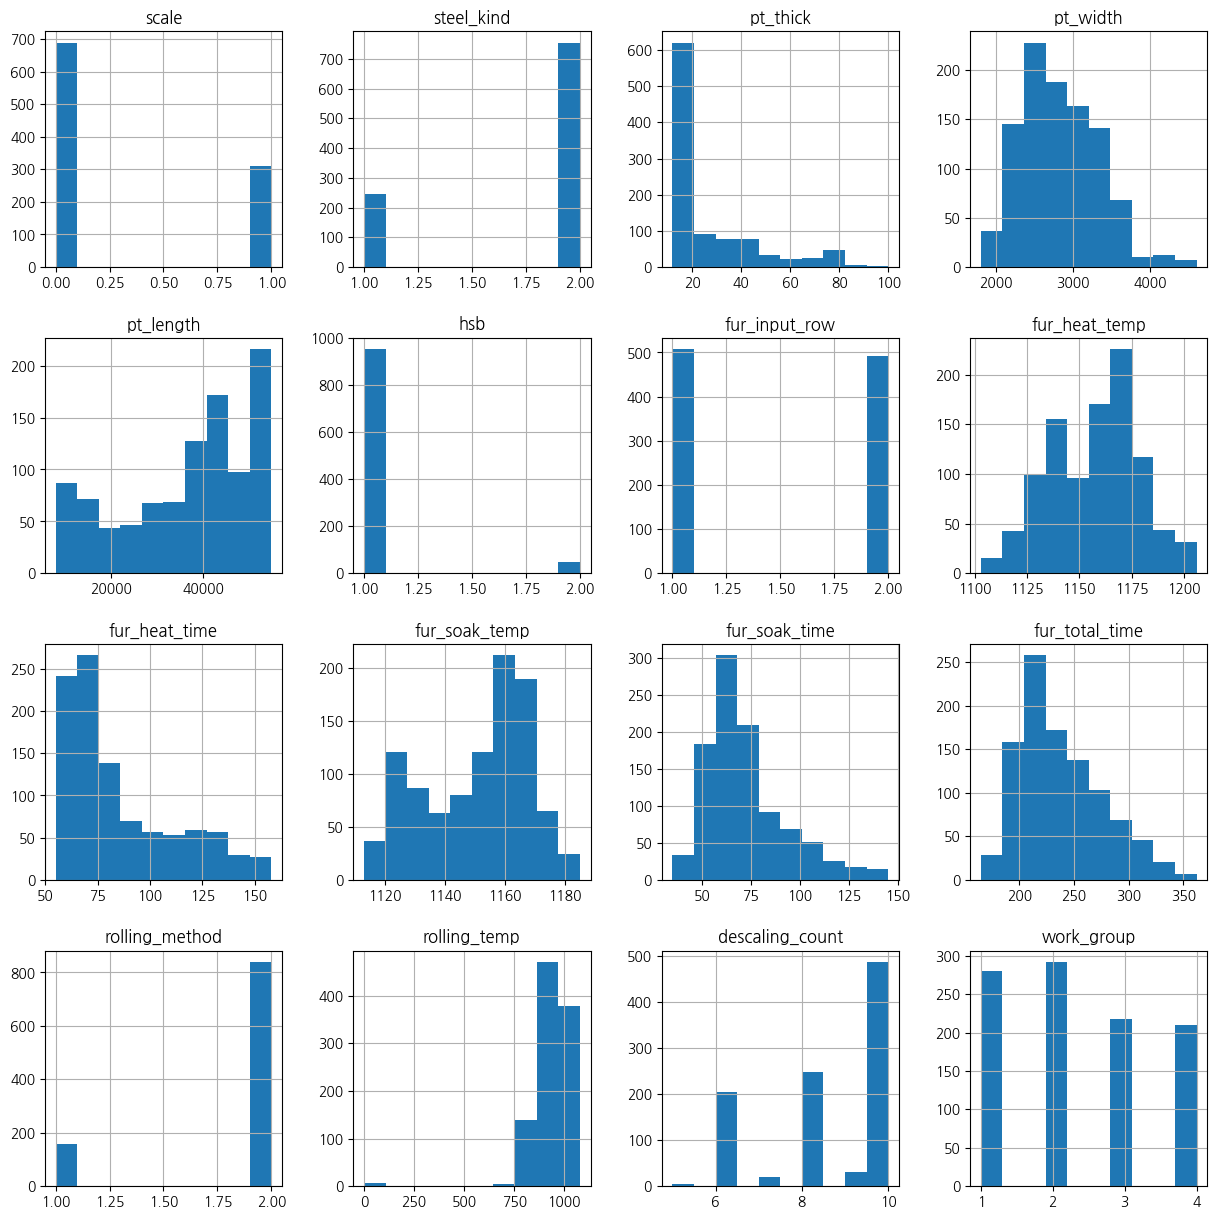

In [52]:
df_raw.hist(figsize = (15, 15)) # 히스토그램 - 데이터의 전반적인 분포를 파악
fig.subplots_adjust(wspace=1.5, hspace=1.5) # 그래프 간격 조절

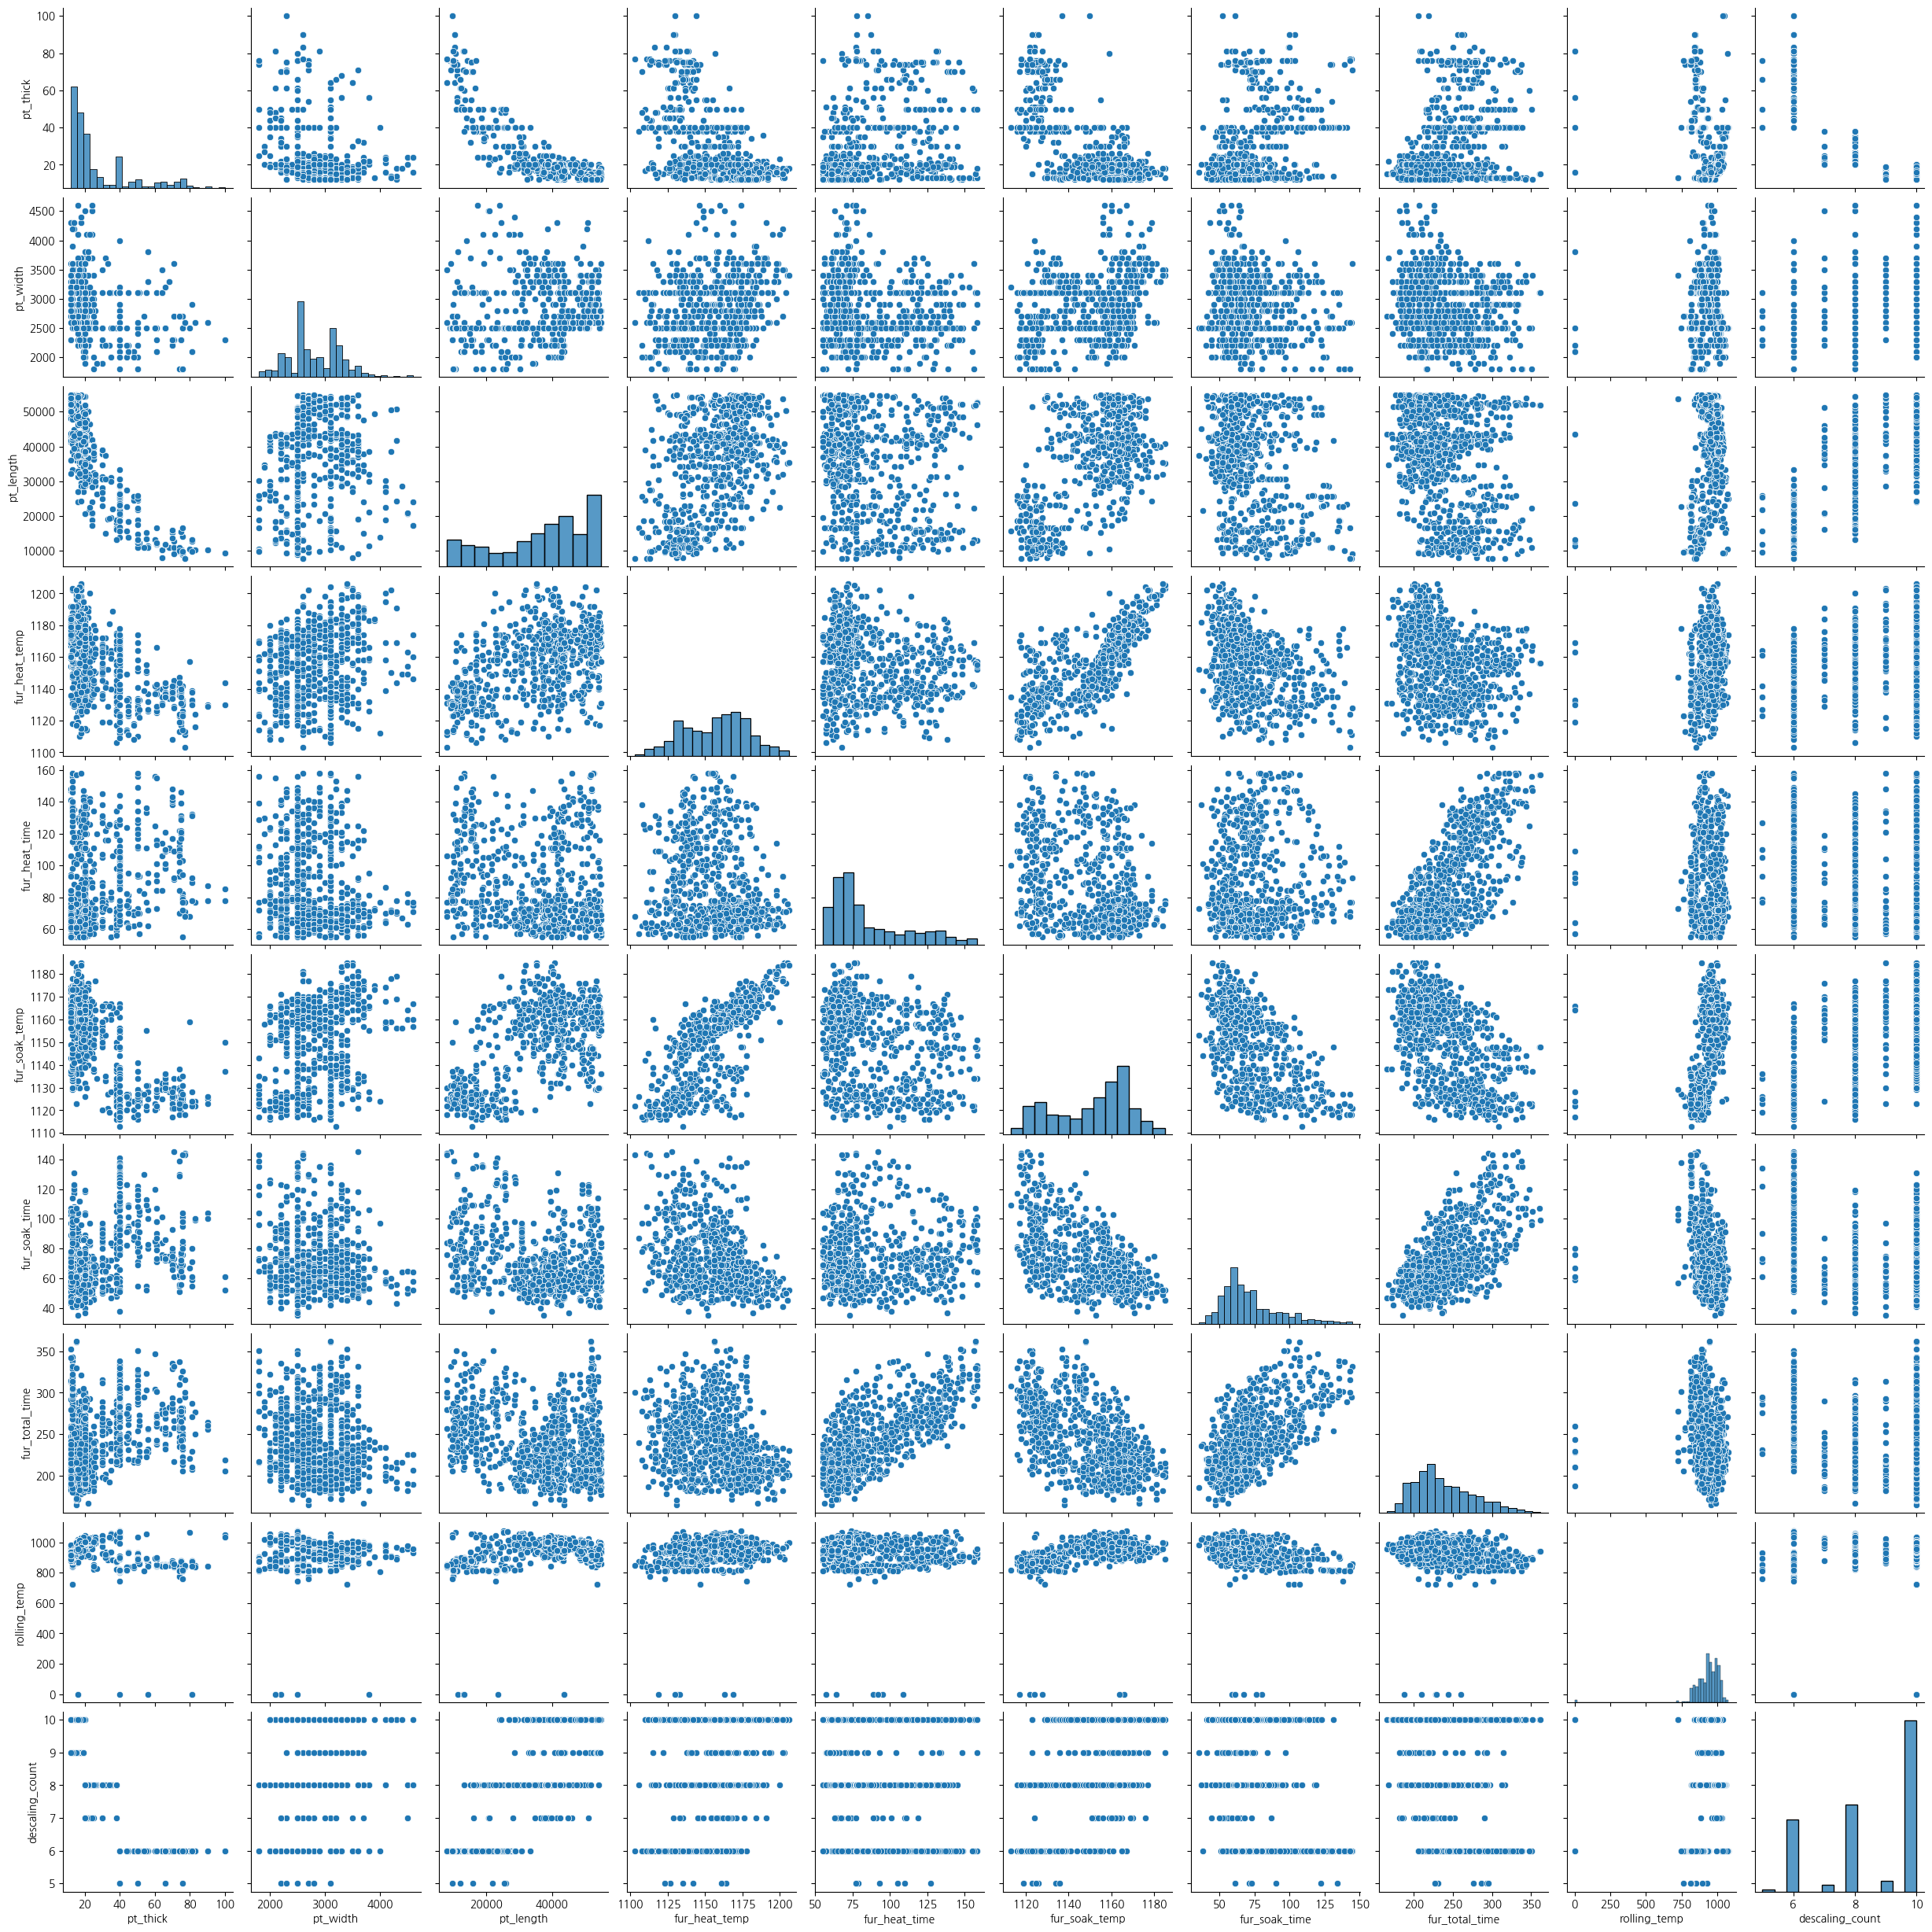

In [31]:
variables = ['scale', 'steel_kind', 'pt_thick', 'pt_width', 'pt_length',
             'hsb', 'fur_no', 'fur_input_row', 'fur_heat_temp', 'fur_heat_time',
             'fur_soak_temp', 'fur_soak_time', 'fur_total_time',
             'rolling_method', 'rolling_temp', 'descaling_count', 'work_group']

sns.pairplot(df_raw[variables])
plt.show()


<Axes: >

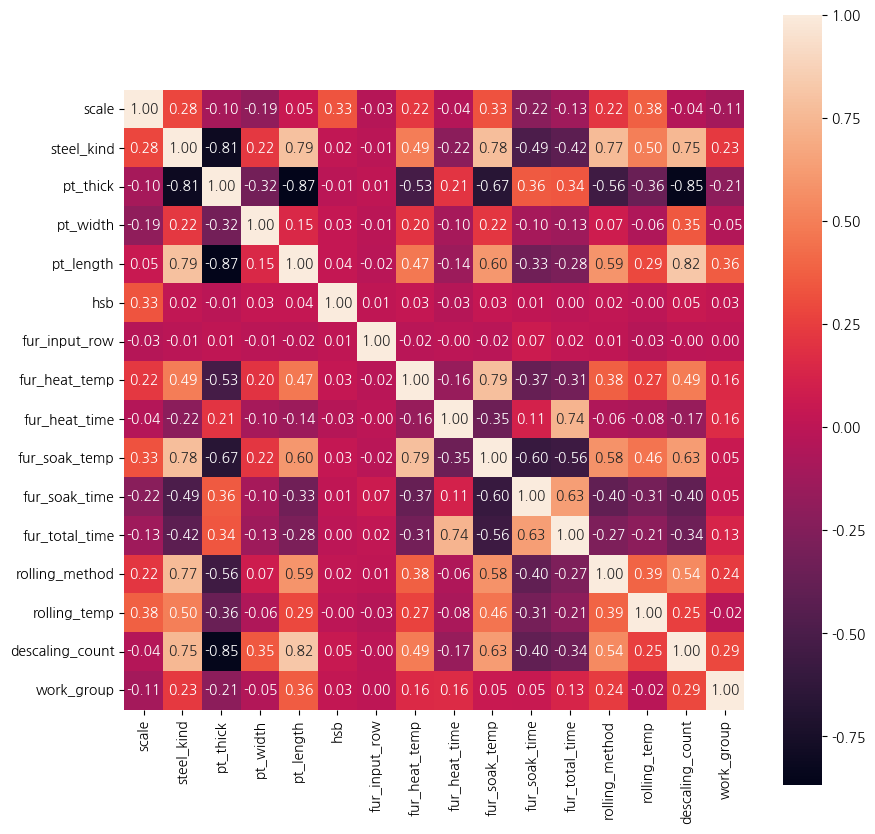

In [51]:
df_numeric = df_raw.select_dtypes(include=np.number) # 수치형 열만 선택하여 새로운 DataFrame 생성
plt.figure(figsize=(10, 10))
sns.heatmap(df_numeric.corr(), annot=True, square=True, fmt='.2f', annot_kws={'size': 10})
#annot=True는 히트맵 셀에 상관계수 값을 표시, square=True는 히트맵 셀을 정사각형 모양으로 표시하도록 지정, annot_kws={'size': 10}는 상관계수 값의 텍스트 크기를 10으로 지정

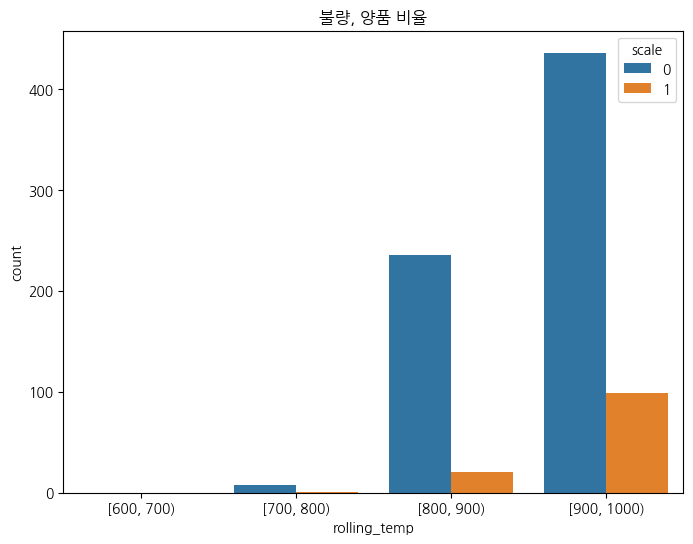

In [59]:
# 압연온도 600~1000 사이의 데이터 추출 
df_raw_rolltemp_600_1000 = df_raw[(df_raw['rolling_temp'] >= 600) & (df_raw['rolling_temp'] <= 1000)]
# 100도 단위로 구간 나누기
df_raw_rolltemp_600_1000['rolling_temp'] = pd.cut(df_raw_rolltemp_600_1000['rolling_temp'], bins=range(600, 1001, 100), right=False)
# 불량, 양품 비율
plt.figure(figsize=(8, 6))
sns.countplot(data=df_raw_rolltemp_600_1000, x='rolling_temp', hue='scale')
plt.title('불량, 양품 비율')
plt.show()